In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

path = '../odds_data/'

files = [filename for filename in os.listdir(path) if os.path.isdir(os.path.join(path,filename))]
odds = []
scores = []

for file in files:
    temp_odds = pd.read_csv(path+file+'/vegas.txt',index_col=0,parse_dates=True)
    temp_playoff_odds = pd.read_csv(path+file+'/vegas_playoff.txt',index_col=0,parse_dates=True)
    temp_scores = pd.read_csv(path+file+'/raw_scores.txt',index_col=0,parse_dates=True)
    odds.append(temp_odds)
    odds.append(temp_playoff_odds)
    scores.append(temp_scores)
    
master_odds = pd.concat(odds,axis=0)
master_scores = pd.concat(scores,axis=0)

master_scores['GAME_ID'] = master_scores['GAME_ID'].apply(lambda row: str(row).zfill(10))
master_odds['GameId'] = master_odds['GameId'].apply(lambda row: str(row).zfill(10))

## EDA on O/U Betting Data
----

In [15]:
def find_columns(columns, keyword):
    #retains and returns the columns (list) that contain the keyword (string).
    
    retained_cols = []
    for feature in columns:
        if feature.find(keyword)!= -1:
            retained_cols.append(feature)
    
    print(f'Found {len(retained_cols)} columns with keyword {keyword}: {retained_cols}')
    
    return retained_cols

In [4]:
OU_cols = find_columns(master_odds, 'OU')
basic_cols = ['Location', 'Team', 'OppTeam', 'TeamId', 'GameId', 'Pts', 'Spread', 'Result', 'Total']

from nba_api.stats.static import teams

nba_teams = teams.get_teams()
teams = [team for team in nba_teams]
id_team_dict={}
for i in range(0,len(teams)):
    id_team_dict.update({teams[i]['id']:teams[i]['abbreviation']})


master_OU = master_odds[basic_cols+OU_cols]
master_OU['year'] = master_OU.index.year

master_OU = master_OU.replace({'TeamId':id_team_dict})
master_OU = master_OU.rename(columns={'TeamId':'TeamAbbr'})

master_OU.head()

Found columns with keyword OU: ['PercentBet_OU', 'Open_Line_OU', 'Open_Odds_OU', 'Pinnacle_Line_OU', 'Pinnacle_Odds_OU', '5dimes_Line_OU', '5dimes_Odds_OU', 'Heritage_Line_OU', 'Heritage_Odds_OU', 'Bovada_Line_OU', 'Bovada_Odds_OU', 'Betonline_Line_OU', 'Betonline_Odds_OU', 'Average_Line_OU', 'Average_Odds_OU', 'Best_Line_OU', 'Worst_Line_OU', 'Best_Odds_OU', 'Worst_Odds_OU']


<ipython-input-4-a371a22dcce0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_OU['year'] = master_OU.index.year


,Location,Team,OppTeam,TeamAbbr,GameId,Pts,Spread,Result,Total,PercentBet_OU,...,Bovada_Odds_OU,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,year
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-17,away,Boston,Cleveland,BOS,0021700001,99.0,-3.0,L,201.0,47.0,...,-110.0,216.0,-110.0,216.17,-106.83,216.5,216.0,-101.0,-110.0,2017
2017-10-17,home,Cleveland,Boston,CLE,0021700001,102.0,3.0,W,201.0,53.0,...,-110.0,216.0,-110.0,216.17,-108.17,216.5,216.0,-105.0,-110.0,2017
2017-10-17,away,Houston,Golden State,HOU,0021700002,122.0,1.0,W,243.0,43.1,...,-115.0,230.5,-115.0,231.75,-109.67,235.0,230.5,-103.0,-115.0,2017
2017-10-17,home,Golden State,Houston,GSW,0021700002,121.0,-1.0,L,243.0,56.9,...,-105.0,230.5,-105.0,231.75,-105.33,235.0,230.5,-100.0,-110.0,2017
2017-10-18,away,Charlotte,Detroit,CHA,0021700003,90.0,-12.0,L,192.0,42.9,...,-110.0,202.0,-115.0,202.17,-107.83,203.0,202.0,-102.0,-115.0,2017


(140.0, 280.0)

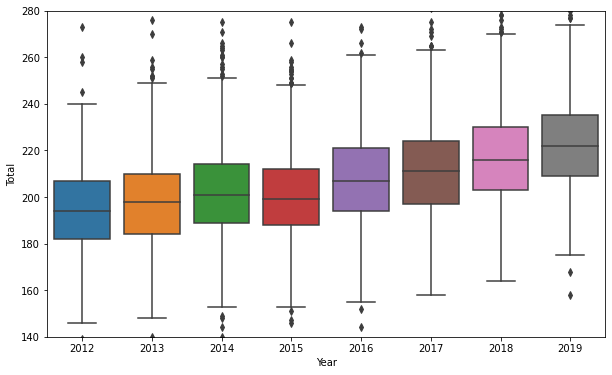

In [5]:
avg_OU_years = master_OU[master_OU['Location'] == 'away'][['Total','year']]
avg_OU_years['Year'] = avg_OU_years.index.year

plt.subplots(figsize=(10,6))
sns.boxplot(x='Year',y='Total',data=avg_OU_years)

plt.ylim(140,280)

We see that scoring across the years changes quite drastically as higher point games become more common.

In [6]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(int(nGraphRow), int(nGraphPerRow), int(i + 1))
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

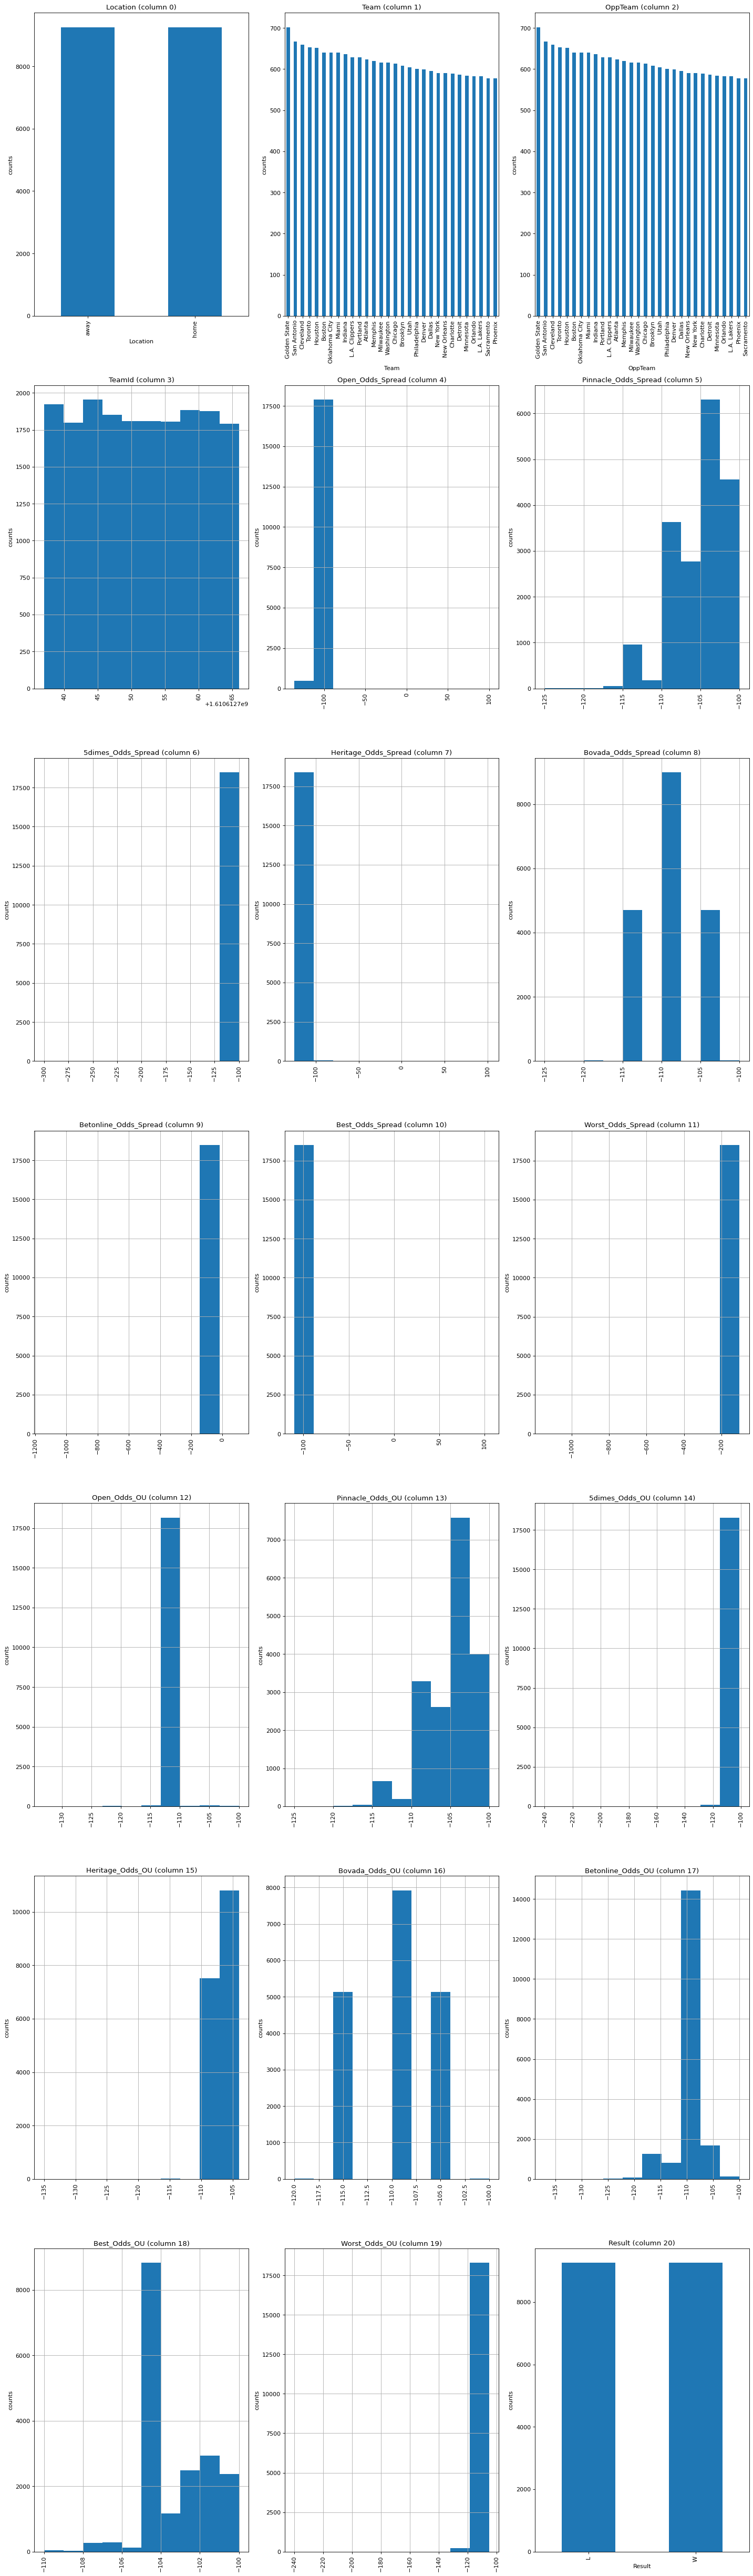

In [7]:
plotPerColumnDistribution(master_odds, 57,3)

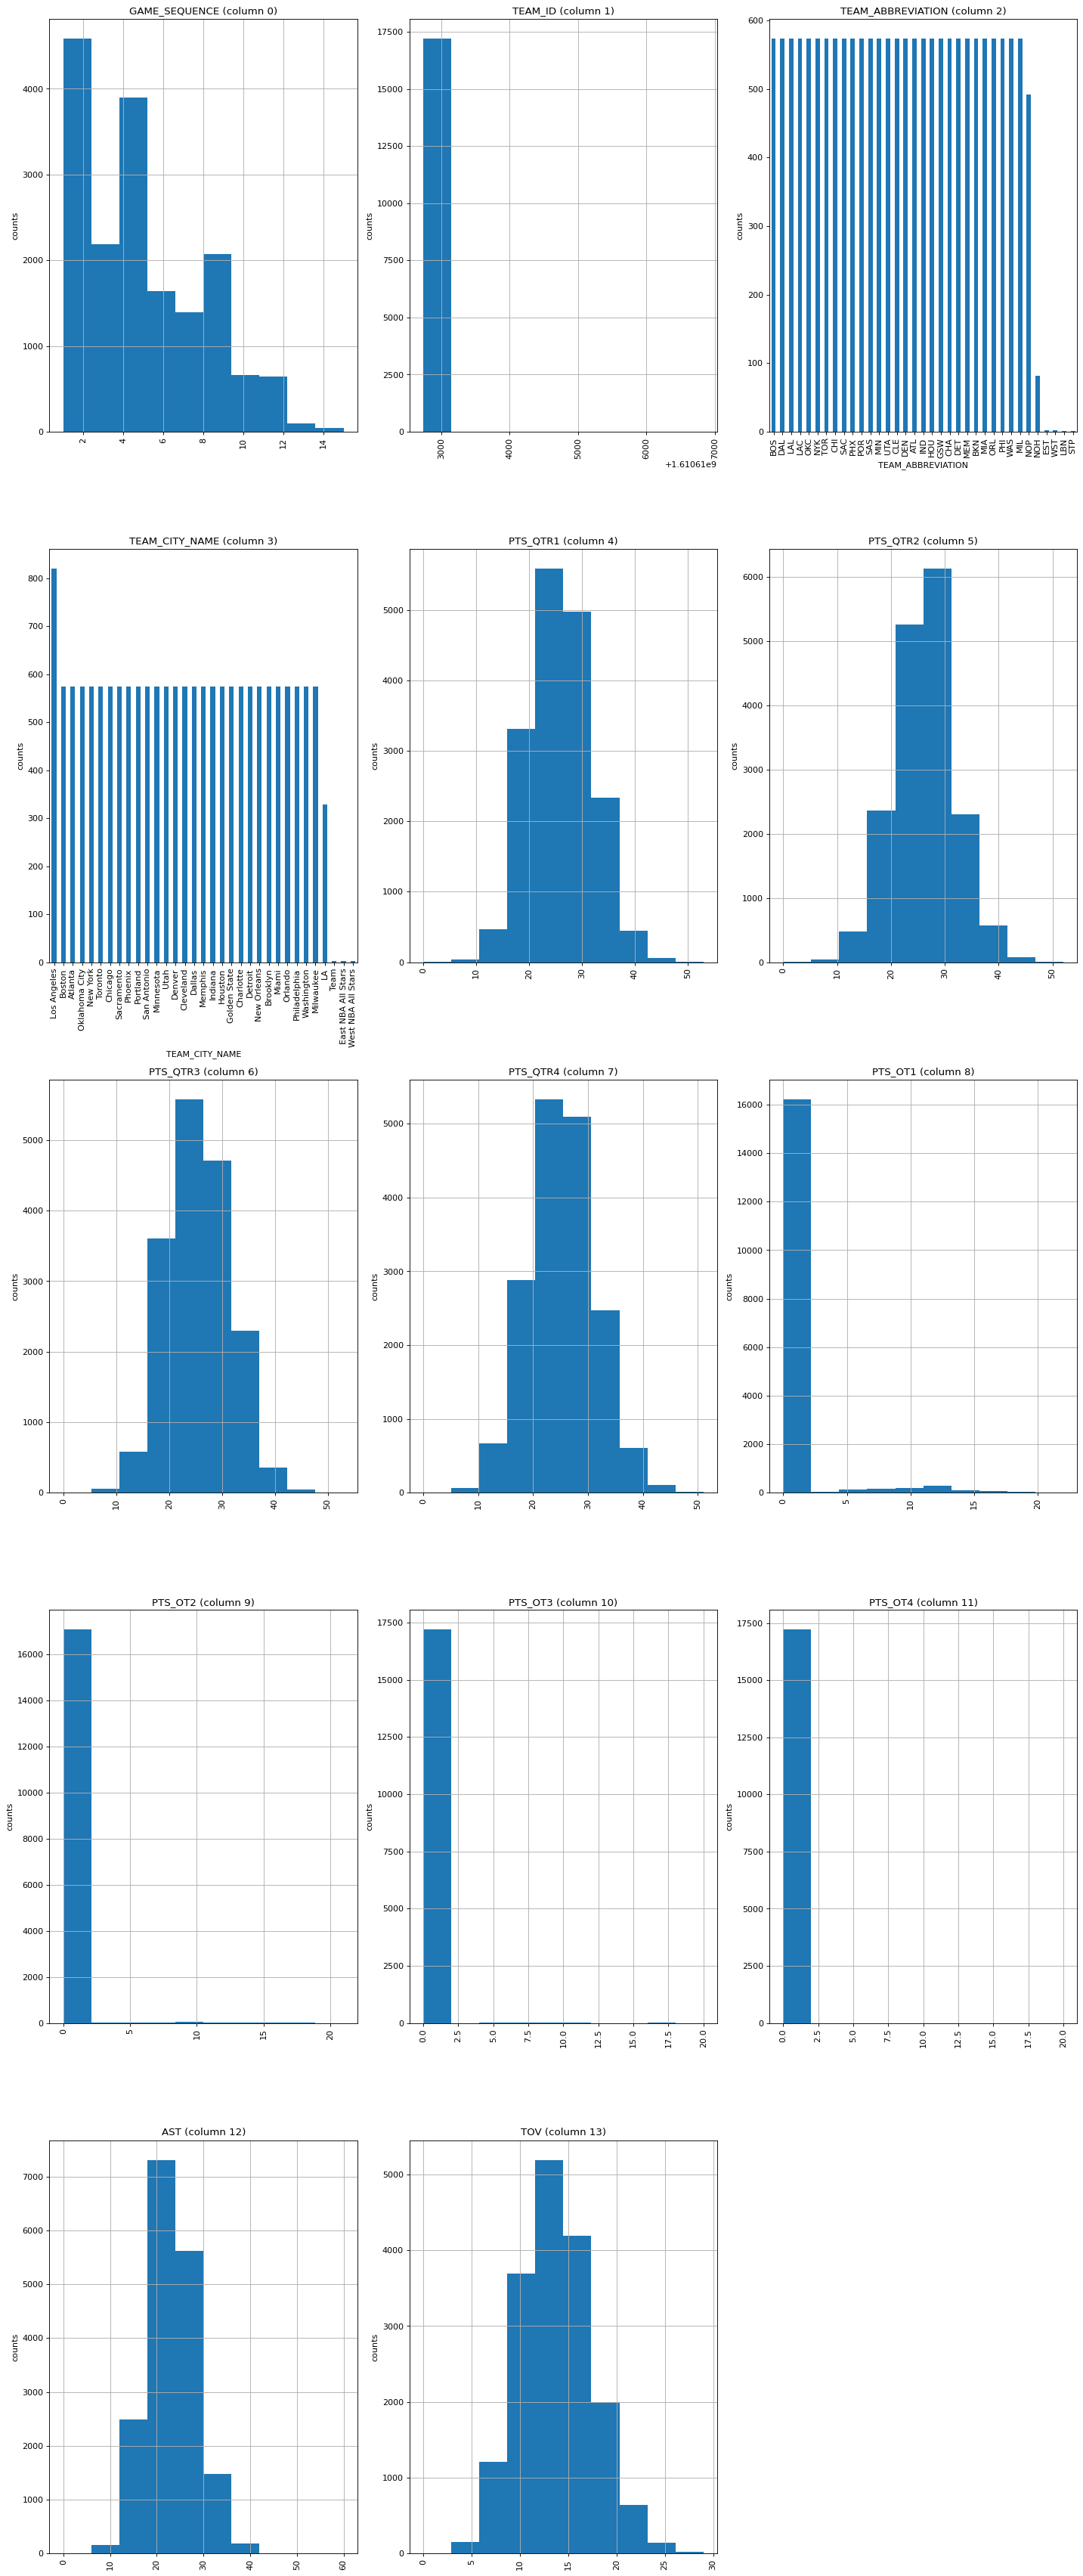

In [8]:
plotPerColumnDistribution(master_scores, 27,3)

In [9]:
master_OU[['Total','Open_Line_OU','Spread']]

,Total,Open_Line_OU,Spread
Date,,,
2017-10-17,201.0,216.5,-3.0
2017-10-17,201.0,216.5,3.0
2017-10-17,243.0,235.0,1.0
2017-10-17,243.0,235.0,-1.0
2017-10-18,192.0,203.0,-12.0
...,...,...,...
2016-06-13,209.0,206.0,-15.0
2016-06-16,216.0,207.0,-14.0
2016-06-16,216.0,207.0,14.0


In [10]:
#Adding columns (binary) indicating over or under for our test data. If total points over: 1, if total points under: 0, if tied: 2.

def OU(OUline, pts):
    if pts > OUline:
        return 1
    elif pts < OUline:
        return 0
    elif pts == OUline:
        return 2

master_OU['O/U'] = master_OU.apply(lambda row: OU(row['Open_Line_OU'],row['Total']),axis = 1 )
master_OU.reset_index(inplace=True)

The distribution and spread for all the features are fine and do not need to be tuned. We now need to consider several additional questions before training the model.

1. What additional game statistics should we include?

2. What subset of games should we train our model with? Playoffs only? Do we include regular season games? Do we use both?

3. How far back do we train the models. As we saw earlier, the average number of points scored per game increases every year. Will using older games in 2013/2014 in our model skew results?

According to wikipedia and other websites, key component used by Vegas for determining initial O/U line are:

1. Pace on offence

2. Efficiency on offence and defense

API fetching is slow so we'll simply import advanced box scores and merge dataframe. The above two statistics are included with the additional boxscore statistics.

In [112]:
path = './boxscore_data/'

files = [filename for filename in os.listdir(path)]
scores=[]

for file in files:
    temp_scores = pd.read_csv(path+file,index_col=0,parse_dates=True)
    scores.append(temp_scores)
    
master_boxscore = pd.concat(scores,axis=0)
master_boxscore = master_boxscore.drop(['season','teamWins','teamLosses'],axis=1)
master_boxscore.reset_index(inplace=True)
master_boxscore = master_boxscore.sort_values(by='gmDate',ascending=False)

master_boxscore.head()

,gmDate,seasonType,teamAbbr,teamLoc,teamRslt,teamDayOff,teamPTS,teamAST,teamTO,teamMin,...,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,opptPoss,opptPace,matchWinner
16826,2019-06-13,Playoffs,TOR,Away,Win,2.0,114.0,25.0,12.0,240.0,...,116.3,120.5,-4.2,0.46,25.27,1.75,0.56,94.6,94.6,TOR
2623,2019-06-13,Playoffs,TOR,Away,Win,2.0,114.0,25.0,12.0,240.0,...,116.3,120.5,-4.2,0.46,25.27,1.75,0.56,94.6,94.6,TOR
16825,2019-06-10,Playoffs,GSW,Away,Win,2.0,106.0,27.0,15.0,240.0,...,111.3,112.4,-1.1,0.45,18.07,1.46,0.46,94.3,94.3,GSW
2622,2019-06-10,Playoffs,GSW,Away,Win,2.0,106.0,27.0,15.0,240.0,...,111.3,112.4,-1.1,0.45,18.07,1.46,0.46,94.3,94.3,GSW
16824,2019-06-07,Playoffs,TOR,Away,Win,1.0,105.0,22.0,9.0,240.0,...,97.0,110.7,-13.7,0.40,23.26,1.53,0.35,94.8,94.8,TOR


Now we can merge the O/U data with the boxscore data using pd.merge(). The dataframe contains all the O/U data and advanced boxscore statistics. As we saw in the EDA earlier, the game changes quite drastically. Since we only have data for up to the 2018-2019 season, we should train the on the three previous season games.

In [12]:
from nba_api.stats.static import teams

away_OU = master_OU[master_OU['Location']=='away']

data = pd.merge(away_OU,master_boxscore,how='left',left_on=['Date','TeamAbbr'],right_on=['gmDate','teamAbbr'])
data = data.drop(columns=['Location','Team','teamLoc','opptLoc'])
data = data.dropna().drop_duplicates(subset=['GameId'])

nba_teams = teams.get_teams()
teams = [team for team in nba_teams]
city_team_dict={}
for i in range(0,len(teams)):
    city_team_dict.update({teams[i]['city']:teams[i]['abbreviation']})

data = data.replace({'OppTeam':city_team_dict})
data = data.rename(columns={'OppTeam':'opptAbbr', 'TeamAbbr':'teamAbbr'})

data.head()

,Date,opptAbbr,teamAbbr,GameId,Pts,Spread,Result,Total,PercentBet_OU,Open_Line_OU,...,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,opptPoss,opptPace,matchWinner
0,2017-10-17,CLE,BOS,0021700001,99.0,-3.0,L,201.0,47.0,216.5,...,102.7,99.7,3.0,0.42,17.59,1.12,0.18,99.3,99.3,CLE
2,2017-10-17,GSW,HOU,0021700002,122.0,1.0,W,243.0,43.1,235.0,...,118.6,119.6,-1.0,0.47,27.92,2.00,0.29,102.0,102.0,HOU
6,2017-10-18,ORL,MIA,0021700005,109.0,-7.0,L,225.0,0.0,207.0,...,110.3,103.6,6.7,0.46,19.43,1.57,0.57,105.2,105.2,ORL
8,2017-10-18,WAS,PHI,0021700006,115.0,-5.0,L,235.0,62.1,215.0,...,115.1,110.3,4.8,0.47,19.04,2.33,0.89,104.3,104.3,WAS
10,2017-10-18,BOS,MIL,0021700007,108.0,8.0,W,208.0,58.6,209.5,...,102.2,110.4,-8.2,0.42,19.70,1.92,1.00,97.9,97.9,MIL


To train our model, we will use averaged data from the previous 5 games and use various statistics from that to calcuate the expected O/U result. We also want to include some additional statistics:

- Number of rest days the players had in the last 5 games.

- Consistency (variance) of the offensive/defensive rating and offensive pace in the last 5 games.

In [48]:
#additional cleanup for findal dataset.

columns_to_drop =[
                'gmDate',
                'Result', 
                'seasonType', 
                'teamRslt', 
                'year', 
                'teamMin', 
                'opptWins', 
                'opptLosses', 
                'opptRslt', 
                'opptMin',
                'matchWinner',
                'GameId',
                'PercentBet_OU',
                'Pinnacle_Line_OU',
                'Pinnacle_Odds_OU',
                '5dimes_Line_OU',
                '5dimes_Odds_OU',
                'Heritage_Line_OU',
                'Heritage_Odds_OU',
                'Bovada_Line_OU',
                'Bovada_Odds_OU',
                'Betonline_Line_OU',
                'Betonline_Odds_OU',
                'Best_Line_OU',
                'Worst_Line_OU',
                'Best_Odds_OU',
                'Worst_Odds_OU',
                'Average_Line_OU',
                'Average_Odds_OU',
                'Open_Odds_OU',
                'Pts']

filtered_data = data.drop(columns=columns_to_drop)
filtered_data = filtered_data.loc[:,~filtered_data.columns.duplicated()].copy()

#save filtered_data as npy file 
filtered_data.to_csv('./_data/filtered_data.csv')

filtered_data = filtered_data.sort_values(by='Date',ascending=False)
filtered_data.head()

,Date,opptAbbr,teamAbbr,Spread,Total,Open_Line_OU,O/U,teamDayOff,teamPTS,teamAST,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,opptPoss,opptPace
7610,2019-06-13,GSW,TOR,4.0,224.0,211.0,1.0,2.0,114.0,25.0,...,73.75,116.3,120.5,-4.2,0.46,25.27,1.75,0.56,94.6,94.6
7608,2019-06-10,TOR,GSW,1.0,211.0,211.5,0.0,2.0,106.0,27.0,...,61.77,111.3,112.4,-1.1,0.45,18.07,1.46,0.46,94.3,94.3
7600,2019-05-30,TOR,GSW,-9.0,227.0,214.5,1.0,9.0,109.0,29.0,...,75.83,126.1,116.5,9.6,0.49,25.53,2.50,0.60,93.6,93.6
7598,2019-05-25,TOR,MIL,-6.0,194.0,214.0,0.0,1.0,94.0,19.0,...,62.71,116.8,109.8,7.0,0.46,21.20,2.00,0.70,85.6,85.6
7594,2019-05-21,TOR,MIL,-18.0,222.0,220.0,1.0,1.0,102.0,30.0,...,86.35,125.1,106.3,18.8,0.47,27.09,2.91,0.82,95.9,95.9
